**First: I start by imports biblios**

In [4]:
import PyPDF2
import numpy as np
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
import rdflib
from rdflib	import Namespace
from owlready2 import *

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


# 1. Data extraction

In [7]:
def create_df(debut_page,fin_page) :
   data = []
   for i in range(debut_page,fin_page):
      pageText = PMBOKReader.getPage(i).extractText()
      data.append(sent_tokenize(pageText)[2:])
   L=[]
   for i in range(len(data)):
      for j in range(len((data[i]))):
          L.append(data[i][j])
   df = pd.DataFrame({'sentence' : L})
   return df

In [8]:
def extract(start,end):    
    text  = ''
    # Lets loop through, to read each page from the pdf file
    while(start < end):
        # Get the specified number of pages in the document
        mani_page  = PMBOKReader.getPage(start)
        # Process the next page
        start += 1
        # Extract the text from the page
        text += mani_page.extractText()
    return text

In [9]:
variables = locals()
pages_dict = {'plan_risk_management':(313,319),'Identify_Risks':(319,328),'perform_qualitative_risk_analysis':(328,334),'perform_quantitative_risk_analysis':(334,342),'plan_risk_Responses':(342,349),'Control_Risks':(349,355)}
for pages in pages_dict:
    variables['text_'+pages] = extract(pages_dict[pages][0],pages_dict[pages][1])

# 2. Data preprocessing

## 2.1 removing undesirable and specific characters

In [10]:
def remove_special_caracters(text):
    text=text.replace('\n A Guide to the Project Management Body of Knowledge (PMBOK\n® Guide) Œ Fifth Edition','',123)
    text=text.replace('Licensed To: Jorge Diego Fuentes Sanchez PMI MemberID: 2399412This copy is a PMI Member benefit, not for distribution, sale, or reproduction.','',123)
    text = text.replace("\nem", " ").replace("™", "'").replace("˚"," ").replace("œ", " ").replace("š"," ")
    text=text.replace('\n',' ') 
    text=text.lower()
    return text

##2.2 Remove undesired ponctuation

In [11]:
def remove_punctuation(text):
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', '!".?#$%&\'()*+,-/:;<=>@[\\]^_`{|}~')
    # return the text stripped of punctuation marks
    return text.translate(translator)

##2.3 Remove stopwords

In [12]:

import nltk
import re
corpus=[]
from nltk.corpus import stopwords
sw = set(stopwords.words('english')) -set([
    "you're", "you've", "she's", "it's", 'who', 'whom', 'am',  'is', 'are', 'was', 'were', 'be','been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',"a",
    'other', 'some',  'no', 'nor', 'not', 'own', 'same',  's', 't', 'can', 'don', "don't", 'should',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", "haven't", 'isn', "isn't",
    'will','such','as', 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'can'])
def stopwords(text): 
# Removing words that contain numbers
    text= re.sub("\S*\d\S*", " ", text).strip()
    text =re.sub('https?://\S+|www\.\S+', ' ', text)
    text=re.sub("\d+", " ", text)
    text = [word for word in text.split() if word not in sw]
    j=" ".join(text)
    corpus.append(j)
    return j

clean data

In [13]:
def clean_data(text):
    text = remove_special_caracters(text)
    text = remove_punctuation(text)
    text = stopwords(text)
    return text

In [14]:
processes = ['text_plan_risk_management',
'text_Identify_Risks',
'text_perform_qualitative_risk_analysis',
'text_perform_quantitative_risk_analysis',
'text_plan_risk_Responses',
'text_Control_Risks']
all_text = ''
for process in processes:
    variables[process] = clean_data(variables[process])
    all_text +=variables[process]

## 2.4 Tokenization

In [16]:
sentences = sent_tokenize(all_text)
words = word_tokenize(all_text)

## 2.5 Lemmetization and Stemming

In [19]:
import gensim
import nltk
from nltk.stem import SnowballStemmer,WordNetLemmatizer
def lemmatize(text):
    stemmer=SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        result.append(lemmatize(token))
    return result

In [21]:
# pos with spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [22]:
import spacy
#nlp = spacy.load("en_core_web_sm") 

doc1 = nlp(all_text)

**100 commonly occurring words with their frequencies**

In [25]:
from collections import Counter
complete_doc = nlp(all_text)
words = [token.text for token in complete_doc if  not token.is_punct]
word_freq = Counter(words)
# 100 commonly occurring words with their frequencies
common_words = word_freq.most_common(100)
print (common_words[:10])

[('project', 383), ('risk', 252), ('management', 245), ('a', 136), ('be', 128), ('communications', 120), ('process', 120), ('information', 119), ('plan', 111), ('is', 107)]


**Unique words**

In [26]:
unique_words = [word for (word, freq) in word_freq.items() if freq == 1]
print (unique_words[:10])

['skills', 'tolistening', 'effectivelyquestioning', 'probing', 'educating', 'fact˜nding', 'con˜rm', 'setting', 'managing', 'persuading']


**list of Verb tokens**

In [27]:
print("Verbs:", [token.text for token in doc1 if token.pos_ == "VERB"][:10]) 

Verbs: ['effectivelyquestioning', 'probing', 'ensure', 'educating', 'be', 'identify', 'setting', 'managing', 'persuading', 'perform']


**POS with nltk**

- Visualise dependency parse using Displacy (Python)

In [28]:
tags=nltk.pos_tag(all_text.split())

## 2.6 Chunking with NLTK

- Extract entities and relations between them

- using biblio nltk

#### extract sentences from text having specific patern 

-  we will extract text with specific pattern. So we startedd with a simple pattern which describe a sentence in this format  
 **NN(Noun) + (VBZ)Verb + Adjective(ADJ) + Noun(NN)**

In [ ]:
import nltk
#"NP:{<DT>?<JJ>*<NN>}"
grammar="Chunk:{<NN.?><VB.?><JJ>*<NN.?>}"
chunkParser = nltk.RegexpParser(grammar)
chunked = chunkParser.parse(tags)
print(chunked)

In [30]:
from nltk.corpus import conll2000
from nltk.chunk import ChunkParserI#Define the chunker class
from nltk.chunk.util import tree2conlltags,conlltags2tree
from nltk.tag import UnigramTagger, BigramTagger
data= conll2000.chunked_sents()

In [31]:
train_data=data[:10900]
test_data=data[10900:]

In [32]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]

In [33]:
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

In [34]:
#Define the chunker class
class NGramTagChunker(ChunkParserI):
    
    def __init__(self,train_sentences,tagger_classes=[UnigramTagger,BigramTagger]):
        train_sent_tags=conll_tag_chunks(train_sentences)
        self.chunk_tagger=combined_tagger(train_sent_tags,tagger_classes)
        
    def parse(self,tagged_sentence):
        if not tagged_sentence:
            return None
        
        pos_tags=[tag for word, tag in tagged_sentence]
        chunk_pos_tags=self.chunk_tagger.tag(pos_tags)
        chunk_tags=[chunk_tag for (pos_tag,chunk_tag) in chunk_pos_tags]
        wpc_tags=[(word,pos_tag,chunk_tag) for ((word,pos_tag),chunk_tag) in zip(tagged_sentence,chunk_tags)]
        
        return conlltags2tree(wpc_tags)   

In [35]:
ntc=NGramTagChunker(train_data)

#evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


## 2.7 Bag of words

In [36]:
import gensim
from gensim import corpora


# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary([all_text.split()])
# convert tokenized documents into a document-term matrix
bow_corpus = [dictionary.doc2bow(text) for text in [all_text.split()]]

In [ ]:
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                               dictionary[bow_doc_0[i][0]], 
bow_doc_0[i][1]))

# 3. Data analysis

## 3.1 TF-ID

In [40]:
#instantiate CountVectorizer() 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text  import CountVectorizer
cv=CountVectorizer() 
# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(sentences)
word_count_vector.shape

(1, 1483)

In [41]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [42]:
# print idf values 
import pandas as pd
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
ability,1.0
planthe,1.0
plans,1.0
planning,1.0
planned,1.0
...,...
environmental,1.0
environment,1.0
entry,1.0
establishing,1.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)
print(vectorizer.get_feature_names())

## 3.2 Distance similarity 

In [44]:
def LevenshteinDistance():
  edDictio={}
  for word in processed:
    a=np.random.choice(processed)
    b=np.random.choice(processed)
    ed_sent=nltk.edit_distance(a,b)
    edDictio[a,b]=ed_sent
  print(edDictio)

## 3.4 World cloud

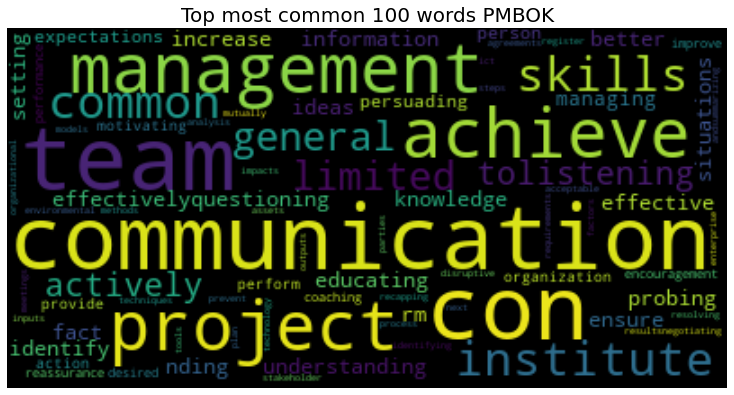

In [46]:
from wordcloud import WordCloud, STOPWORDS
import imageio
import matplotlib.pyplot as plt
import nltk


# Get 100 words based on the 
words_except_stop_dist = nltk.FreqDist(w for w in words[:100]) 
wordcloud = WordCloud(stopwords=set(STOPWORDS),background_color='black').generate(" ".join(words_except_stop_dist))
plt.imshow(wordcloud,interpolation = 'bilinear')
fig=plt.gcf()
fig.set_size_inches(10,12)
plt.axis('off')
plt.title("Top most common 100 words PMBOK",fontsize=20)
plt.tight_layout(pad=0)
plt.savefig('PMBOK_cost_time_scop_top_100.jpeg')

**Synonym**

In [47]:
AllConcepts=[]
AllRelations=[]
for tok in doc1:
    if tok.pos_=="NOUN":
        AllConcepts.append(tok.text)
    if tok.pos_=="VERB":
        AllRelations.append(tok.text)

- find_synonym_ontology(word) : returns all the synonyms of a word even the synonyms that doesn't exist in PMBOK

In [48]:
from nltk.corpus import wordnet
def find_synonym_ontology(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lm in syn.lemmas():
            synonyms.append(lm.name())
    return list(set(synonyms))

In [49]:
# Examples
print("Synonyms of project : ", find_synonym_ontology("project"))

Synonyms of project :  ['jut', 'picture', 'plan', 'undertaking', 'project', 'labor', 'contrive', 'visualize', 'propose', 'task', 'send_off', 'visualise', 'throw', 'externalize', 'stick_out', 'fancy', 'projection', 'externalise', 'cast', 'design', 'jut_out', 'protrude', 'see', 'figure', 'image', 'envision']


-  returns all the synonyms of a word even the synonyms that exists in PMBOK this method is for concepts

In [50]:
def synonymConceptOntoPMB(term):

    if term not in AllConcepts :
        return "it haven't" 
    else :
        syno_list=[]
        temp_list=[]
        syno_list = find_synonym_ontology(term)
        if len(syno_list) != 0 :
            for syno  in syno_list :
                if syno in AllConcepts  and syno != term :
                    temp_list.append(syno)
                    
        return temp_list

In [51]:
print("Synonym of project in our ontology :", synonymConceptOntoPMB('project'))
print("Synonym of scope in our ontology :", synonymConceptOntoPMB('scope'))

Synonym of project in our ontology : ['plan', 'design', 'figure']
Synonym of scope in our ontology : ['background', 'range']


In [52]:
def synonymrelationOntoPMB(term):
    
    if term not in AllRelations :
        return "it haven't"
    else :
        syno_list=[]
        temp_list=[]
        syno_list = find_synonym_ontology(term)
        if len(syno_list) != 0 :
            for syno  in syno_list :
                if syno in AllRelations  and syno != term :
                    temp_list.append(syno)
                    
        return temp_list

In [53]:
print("Synonym relations of work in our ontology :", synonymrelationOntoPMB('work'))
print("Synonym relations of build in our ontology :", synonymrelationOntoPMB('build'))
print("Synonym relations of create in our ontology :", synonymrelationOntoPMB('create'))

Synonym relations of work in our ontology : ['bring', 'make', 'exercise', 'operate', 'form']
Synonym relations of build in our ontology : it haven't
Synonym relations of create in our ontology : ['make']


<h1 align="center"> Extraction Triple </h1>

In [54]:
def triple():
    Triple=[]
    try:
        for subtree in chunked.subtrees(filter=lambda t: t.label() == 'Chunk'):
              Triple.append(subtree)
    except Exception as e:
        print(str(e))
    
    return Triple

In [55]:
print(len(triple()))

566


# Extract Patterns (concepts , relation , object)

**Here we user spacy and matcher from spacy**

In [56]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 

In [57]:
Concepts=[]
relation=[]
object=[]
for i in range(len(triple())-1):
    Concepts.append(triple()[i][0][0])
    relation.append(triple()[i][1][0])
    object.append(triple()[i][2][0])
obj= pd.DataFrame(columns=['Concepts','relation','object'])
obj['Concepts']=Concepts
obj['relation']=relation
obj['object']=object

In [58]:
obj.drop_duplicates().reset_index(drop=True)

,Concepts,relation,object
0,skills,are,common
1,organization,perform,action
2,parties,resolving,con
3,inputs,project,management
4,plan,stakeholder,register
...,...,...,...
481,section,perform,qualitative
482,process,include,roles
483,responsibilities,conducting,risk
484,activities,risk,management


In [59]:
list(obj["Concepts"][:10])

['skills',
 'organization',
 'parties',
 'inputs',
 'plan',
 'assets',
 'meetings',
 'documents',
 'plan',
 'reports']

In [60]:
len(obj)

565

- first we extract Concepts ,relations , objects

In [61]:
obj=obj[(obj.Concepts.str.len() > 3)]
obj=obj[(obj.object.str.len() >3)]

In [62]:
obj

,Concepts,relation,object
0,skills,are,common
1,organization,perform,action
3,inputs,project,management
4,plan,stakeholder,register
5,assets,tools,techniques
...,...,...,...
560,responsibilities,conducting,risk
561,activities,risk,management
562,matrix,revised,stakeholders
563,plan,risk,management


In [63]:
common_words = word_freq.most_common(100)
print (common_words[:10])

[('project', 383), ('risk', 252), ('management', 245), ('a', 136), ('be', 128), ('communications', 120), ('process', 120), ('information', 119), ('plan', 111), ('is', 107)]


**We keep  only the common concepts**

In [64]:
df_concept=list(obj["Concepts"])
for i in df_concept:
    if i not in common_words:
        df_concept.remove(i)
#print(df_concept)
print(len(df_concept))
df_concept=set(df_concept)

273


*Text Segmentation*

In [159]:
import pdfplumber
def process_segmentation() : 
 ch=''
 names ='' 
 start = 0
 process_df = pd.DataFrame(columns=['Process Name','start', 'Corpus'])
 with pdfplumber.open("PMBOK.pdf") as pdf:
  for i in range(338,380) :
     page = (pdf.pages[i]).extract_text()
     for line in page.split('\n') :
        if re.match('\d{2}.\d\s[A-Za-z]+\s[A-Za-z]',line) :
           if start != 0 :
               process_df = process_df.append({'Process Name': name,'start':start }, ignore_index=True)
           ch = ''
           start = i
           name = line[5:]
           ch=ch+'. '+line
  process_df = process_df.append({'Process Name': name,'start':start, 'Corpus': ch[1:] }, ignore_index=True )
  return (process_df)


In [161]:
process_df = process_segmentation()

In [340]:
import pdfplumber 
ch=''
with pdfplumber.open("PMBOK.pdf") as temp:
 for i in range(339,379) :
   first_page = temp.pages[i]
   ch=ch+first_page.extract_text()


In [374]:
import pdfplumber 
all_text=''
with pdfplumber.open("PMBOK.pdf") as temp:
 for i in range(0,610) :
   first_page = temp.pages[i]
   all_text=all_text+first_page.extract_text()

In [337]:
import re
inputs_titles = re.compile(r'\d+\..+: Inputs\n')
tools_and_techniques = re.compile(r'\d+\..+: tools and techniques\n') 
outputs_titles = re.compile(r'\d+\..+: outputs\n')
get_subtiltles = re.compile(r'[^|\n](\d+\.){2,4}\d+ [a-z|\s|A-Z]+(\d+)?\n') 
title = re.compile(r'\d+ (.+): Inputs\n')


In [437]:
#Extraire tous les titres avec : Inputs
sections = inputs_titles.finditer(ch) 
df = []
inputs = [] 
tt = []
outputss=[]
lst_sec = [elem for elem in sections]
dicto = {}
lst_process=[]
lst_inputs =[]
lst_tt = []
lst_outputs=[]
final_list = []
for i in range(0,len(lst_sec)):
      dicto[title.search(lst_sec[i].group()).group(1)]={}
      lst_process.append(title.search(lst_sec[i].group()).group(1))
      # print("processus : ", title.search(lst_sec[i].group()).group(1)) 
      #Extraire toute la partie entre 2 processus
      df.append(title.search(lst_sec[i].group()).group(1))
      str_between = ch[int(lst_sec[i].span()[1]):int(lst_sec[i+1].span()[0])] 
      t_and_t = tools_and_techniques.search(str_between)
      ch_inputs_techniques = str_between[:int(t_and_t.span()[0])]
      lst_sub_inputs = get_subtiltles.finditer(ch_inputs_techniques)
      #######Liste des inputs
      lst2 = [a.group().split('\n')[0] for a in lst_sub_inputs]
      #print(lst2)
      l=list()
      nom_input = "p"+str(i+1)+"_inputs" 
      l.append(nom_input)
      dicto[title.search(lst_sec[i].group()).group(1)]["inputs"]={}
      for j in lst2 : 
         a=j
         a=a.replace('\n','')
         a = re.sub(r'[*\d]', '', a)
         a=a.replace('.','')
         a = re.sub(r"^\s+","",a) 
         l.append(a)
        #inputs
         #*************************************************
         lst_inputs.append(j)
         final_list.append(j)
         dicto[title.search(lst_sec[i].group()).group(1)]["inputs"][j]={}
         #*************************************************
         print("\t"+j) 
      inputs.append(l)
      #####End liste des inputs
      #[print("\t"+x.group().split('\n')[0]) for x in lst_sub_inputs]
      print(t_and_t.group())
      outputs = outputs_titles.search(str_between)
      ch_techniques_outputs = str_between[int(t_and_t.span()[1]):int(outputs.span()[0])] 
      lst_sub_tt = get_subtiltles.finditer(ch_techniques_outputs)
      ######Liste des tt
      lst2 = [a.group().split('\n')[0] for a in lst_sub_tt]
      #print(lst2)
      l=list()
      nom_tt = "p"+str(i+1)+"_tt"
      l.append(nom_tt)
     #*************************************************
      dicto[title.search(lst_sec[i].group()).group(1)]["tools and techniques"]={}
     #*************************************************
      for j in lst2 : 
         a=j
         a=a.replace('\n','')
         a = re.sub(r'[*\d]', '', a)
         a=a.replace('.','')
         a = re.sub(r"^\s+","",a) 
         l.append(a)
         #tools & techniques
        #*************************************************
         lst_tt.append(j)
         dicto[title.search(lst_sec[i].group()).group(1)]["tools and techniques"][j]={}
         final_list.append(j)
        #*************************************************
         print("\t"+j) 
      tt.append(l)
      ######End liste des tt
      #[print("\t"+x.group().split('\n')[0]) for x in lst_sub_tt]
      print(outputs.group())
      ch_outputs = str_between[int(outputs.span()[1]):]
      lst_sub_outputs = get_subtiltles.finditer(ch_outputs)
      ######Liste des outputs
      lst2 = [a.group().split('\n')[0] for a in lst_sub_outputs]
      #print(lst2)
      l=list()
      nom_output = "p"+str(i+1)+"_outputs" 
      l.append(nom_output)
      #************************************************* 
      dicto[title.search(lst_sec[i].group()).group(1)]["outputs"]={}
      for j in lst2 : 
         a=j
         a=a.replace('\n','')
         a = re.sub(r'[*\d]', '', a)
         a=a.replace('.','')
         a = re.sub(r"^\s+","",a) 
         l.append(a)
         #outputs
        #*************************************************
         lst_outputs.append(j)
         dicto[title.search(lst_sec[i].group()).group(1)]["outputs"][j]={}
         final_list.append(j)
        #*************************************************
         print("\t"+j) 
      outputss.append(l)
      ######End liste des outputs
      #[print("\t"+x.group().split('\n')[0]) for x in lst_sub_outputs if '-' not in x.gro
      print('-'*70)

11.1.1 Plan risk Management: Inputs

	11.1.1.1 Project Management Plan
	11.1.1.2 Project charter
	11.1.1.3 Stakeholder register
	11.1.1.4 Enterprise Environmental Factors
	11.1.1.5 organizational Process Assets
11.1.2 Plan risk Management: tools and techniques

	11.1.2.1 Analytical techniques
	11.1.2.2 Expert Judgment
	11.1.2.3 Meetings
11.1.3 Plan risk Management: outputs

	11.1.3.1 risk Management Plan
----------------------------------------------------------------------
11.2.1 Identify risks: Inputs

	11.2.1.1 risk Management Plan 11
	11.2.1.2 cost Management Plan
	11.2.1.3 Schedule Management Plan
	11.2.1.4 Quality Management Plan
	11.2.1.5 Human resource Management Plan
	11.2.1.6 Scope Baseline
	11.2.1.7 Activity cost Estimates
	11.2.1.8 Activity duration Estimates
	11.2.1.9 Stakeholder register
	11.2.1.10 Project documents
	11.2.1.11 Procurement documents
	11.2.1.12 Enterprise Environmental Factors
	11.2.1.13 organizational Process Assets
11.2.2 Identify risks: tools and techniq

In [439]:
text = ch.replace("\n"," ")
h=0
#iterating processes
for i,process in enumerate(dicto.keys()):
    #iterating inputs/outputs/TT
    for j,el in enumerate(dicto[process].keys()):
        #iterating values
        for k,element in enumerate(dicto[process][el]):
            if h < len(final_list)-2:
                dicto[process][el][element]=[text[text.index(final_list[h]):text.index(final_list[h+1])]]
            else:
                dicto[process][el][element]=[text[ch.index(final_list[h]):]]
            h=h+1
            

In [423]:
def text_between(corpus,start,end):
    return corpus[corpus.index(start):corpus.index(end)]


In [397]:
len(lst_sections)

29

In [372]:
lst_sections = []
for i,process in enumerate(dicto.keys()):
    for j,el in enumerate(dicto[process].keys()):
        for k,element in enumerate(dicto[process][el]):
            text = dicto[process][el][element][0]
            if "Described in Section " in text:
                temp=""
                compt = 0
                substr = text[text.index("Described in Section "):][21:]
                while (compt<len(substr) and substr[compt]!=" "):
                    temp+=substr[compt]
                    compt+=1
                section="Described in Section " + temp
                lst_sections.append(section)
lst_sections                 

['Described in Section 4.1.3.1.',
 'Described in Section 13.1.3.1.',
 'Described in Section 2.1.5.',
 'Described in Section 2.1.4.',
 'Described in Section 11.1.3.1.',
 'Described in Section 7.1.3.1.',
 'Described in Section 6.1.3.1.',
 'Described in Section 8.1.3.1.',
 'Described in Section 9.1.3.1.',
 'Described in Section 5.4.3.1.',
 'Described in Section 7.2.3.1.',
 'Described in Section 6.5.3.1.',
 'Described in Section 13.1.3.1.',
 'Described in Section 2.1.5.',
 'Described in Section 2.1.4.',
 'Described in Section 11.1.3.1.',
 'Described in Section 5.4.3.1.',
 'Described in Section 11.2.3.1.',
 'Described in Section 2.1.5.',
 'Described in Section 2.1.4.',
 'Described in Section 11.1.3.1.',
 'Described in Section 7.1.3.1.',
 'Described in Section 6.1.3.1.',
 'Described in Section 11.2.3.1.',
 'Described in Section 2.1.5.',
 'Described in Section 2.1.4.',
 'Described in Section 4.2.3.1.',
 'Described in Section 4.3.3.2.',
 'Described in Section 4.4.3.2.']

In [442]:
compt=0
for i,process in enumerate(dicto.keys()):
    for j,el in enumerate(dicto[process].keys()):
        for k,element in enumerate(dicto[process][el]):
            text = dicto[process][el][element][0]
            if "Described in Section " in text:
                dicto[process][el][element].append(text_between(all_text,lst_sections[0],lst_sections[1]))
                compt+=1
            else:
                dicto[process][el][element].append("No section")
            

In [444]:
import json
with open('final.json', 'w') as fp:
    json.dump(dicto, fp)

# Concepts : df_concept

- we define all patterns that can be an (instance , subclass)

In [445]:
relations = ['is a','such as','kind of','including','have','part','member','instance','and or other','especially','like','in']

## we define All pattern here

In [446]:
#define the pattern 
patternISA = [  {'DEP':'amod','OP':"?"}, # adjectival modifier
                {'POS':'NOUN'}, 
                {'LOWER': 'is'},  {'LOWER': 'a'}, 
                {'POS': 'NOUN'}]
# Pattern such as
pattern2 = [  {'DEP':'amod','OP':"?"}, # adjectival modifier 
              {'POS':'NOUN'}, 
              {'LOWER': 'such'},  {'LOWER': 'as'},
              {'POS':'PROPN'}]
# Pattern kind of
pattern3 = [  {'DEP':'amod','OP':"?"}, # adjectival modifier 
              {'POS':'NOUN'}, 
            {'LOWER': 'kind'},  {'LOWER': 'of'}, 
              {'POS':'PROPN'}]
# Pattern include 
pattern4 = [  {'DEP':'amod','OP':"?"}, # adjectival modifier 
              {'POS':'NOUN'}, 
           {'LOWER': 'include'}, 
              {'DEP':'amod','OP':"?"}, # adjectival modifier 
            {'POS':'NOUN'}]
# Pattern have
pattern5 = [  {'DEP':'amod','OP':"?"}, # adjectival modifier 
              {'POS':'NOUN'}, 
           {'LOWER': 'have'}, 
              {'DEP':'amod','OP':"?"}, # adjectival modifier 
           {'POS':'NOUN'}]
# Pattern part
pattern6 = [  {'DEP':'amod','OP':"?"}, # adjectival modifier 
              {'POS':'NOUN'}, 
           {'LOWER': 'part'}, 
              {'DEP':'amod','OP':"?"}, # adjectival modifier 
           {'POS':'NOUN'}]
# Pattern member
pattern7 = [  {'DEP':'amod','OP':"?"}, # adjectival modifier 
              {'POS':'NOUN'}, 
           {'LOWER': 'member'}, 
              {'DEP':'amod','OP':"?"}, # adjectival modifier 
           {'POS':'NOUN'}]
# Pattern instance
pattern8 = [  {'DEP':'amod','OP':"?"}, # adjectival modifier 
              {'POS':'NOUN'}, 
           {'LOWER': 'instance'}, 
              {'DEP':'amod','OP':"?"}, # adjectival modifier 
           {'POS':'NOUN'}]

#define the pattern  and|or 
pattern9 = [{'DEP':'amod', 'OP':"?"}, 
           {'POS':'NOUN'}, 
           {'LOWER': 'and', 'OP':"?"}, 
           {'LOWER': 'or', 'OP':"?"}, 
           {'LOWER': 'other'}, 
           {'POS': 'NOUN'}] 
# Pattern especially
pattern10 = [  {'DEP':'amod','OP':"?"}, # adjectival modifier 
              {'POS':'NOUN'}, 
           {'LOWER': 'especially'}, 
              {'DEP':'amod','OP':"?"}, # adjectival modifier 
           {'POS':'NOUN'}]
# Pattern like
pattern11 = [{'DEP':'compound', 'OP':"*"},
           {'POS':'NOUN'},
           {'LOWER': 'like'},
           {'DEP':'compound', 'OP':"*"},
           {'POS': 'NOUN'}]
# Pattern In
pattern12 = [{'DEP':'compound', 'OP':"*"},
           {'POS':'NOUN'},
           {'LOWER': 'In'},
           {'DEP':'compound', 'OP':"*"},
           {'POS': 'NOUN'}]

- Let’s extract those patterns from the text:

In [447]:
matcher = Matcher(nlp.vocab) 
matcher.add("All match", [patternISA,pattern2,pattern3,pattern4,pattern5,pattern6,pattern7,pattern8,pattern10,pattern11,pattern12])
matchess = matcher(doc1)
spans = [doc1[start:end] for _, start, end in matchess]

In [448]:
X_Relation_Y=[]
for span in spacy.util.filter_spans(spans):
    X_Relation_Y.append(re.split('( is a )',span.text))
   # 'is a','such as','kind of','including','have','part','member','instance','and or other','especially','like','in'
df_X_Relation_Y = pd.DataFrame(X_Relation_Y,columns=['Y','Relation','X'])
df_X_Relation_Y = df_X_Relation_Y.dropna().reset_index().drop(['index'],axis=1)
df_X_Relation_Y

,Y,Relation,X
0,information,is a,need
1,technology,is a,need
2,use,is a,need
3,environment,is a,need
4,information,is a,need
5,plan,is a,component
6,technique,is a,risk
7,context,is a,combination
8,plan,is a,component
9,matrix,is a,grid


In [449]:
df_class_subclass = pd.DataFrame()
df_class_subclass['class'] = df_X_Relation_Y['Y']
df_class_subclass['subclass'] = df_X_Relation_Y['X']

In [450]:
df_class_subclass

,class,subclass
0,information,need
1,technology,need
2,use,need
3,environment,need
4,information,need
5,plan,component
6,technique,risk
7,context,combination
8,plan,component
9,matrix,grid


In [451]:
obj

,Concepts,relation,object
0,skills,are,common
1,organization,perform,action
3,inputs,project,management
4,plan,stakeholder,register
5,assets,tools,techniques
...,...,...,...
560,responsibilities,conducting,risk
561,activities,risk,management
562,matrix,revised,stakeholders
563,plan,risk,management


In [452]:
df_data = obj[obj['Concepts'].isin(df_class_subclass['class'])].drop_duplicates().reset_index(drop=True)
df_data.columns = ['Concepts','relation','Individual']
df_data


,Concepts,relation,Individual
0,plan,stakeholder,register
1,plan,work,performance
2,plan,updates,project
3,plan,project,communications
4,information,needs,requirements
5,plan,communications,management
6,information,is,neededwhile
7,information,needs,methods
8,plan,provides,information
9,register,provides,information


In [454]:
df_data['Range'] = "string"
df_data.drop_duplicates().reset_index(drop=True)

,Concepts,relation,Individual,Range
0,plan,stakeholder,register,string
1,plan,work,performance,string
2,plan,updates,project,string
3,plan,project,communications,string
4,information,needs,requirements,string
5,plan,communications,management,string
6,information,is,neededwhile,string
7,information,needs,methods,string
8,plan,provides,information,string
9,register,provides,information,string


# OWL with rdflib

In [575]:
from rdflib.namespace import DC, DCTERMS, DOAP, FOAF, OWL, RDF, RDFS, SKOS, VOID, XMLNS, XSD
from rdflib import URIRef, BNode, Literal, Namespace, Graph
from rdflib.extras import describer 
import pandas as pd 

- create a Graph

In [591]:
g= Graph()
g.bind("owl",OWL)
g.bind("pr","http://example.com/h#")#Bind prefix to namespace
ns_url = "http://example.com/h#"
# Create an RDF URI node to use as the subject for multiple triples
g.add((URIRef('http://example.com/h'), RDF.type, OWL.Ontology ))

<Graph identifier=N27d2dd7dc8cd497eb368040495413813 (<class 'rdflib.graph.Graph'>)>

- we start by create concepts

## Create concept

In [592]:
for c in df_concept:
    cl = URIRef(ns_url+c.replace(" ","_"))
    g.add((cl, RDF.type, OWL.Class))    # add tag

## create individuel and concept

In [ ]:
for i in range(len(df_data)):
    c = URIRef(ns_url+df_data.loc[i,'Concepts'].replace(" ","_"))
    ind =URIRef(ns_url+df_data.loc[i,'Individual'].replace(" ","_"))
    g.add((ind,RDF.type,c))
for i,process in enumerate(dicto.keys()):
    for j,el in enumerate(dicto[process].keys()):
        for k,element in enumerate(dicto[process][el]):
            c= URIRef(ns_url+process.replace(" ","_"))
            ind = URIRef(ns_url+element.replace(" ","_")[9:])
            relation =  URIRef(ns_url+("has "+str(el)).replace(" ","_"))
            is_relation = URIRef(ns_url+("is "+str(el)).replace(" ","_"))
            definition = URIRef(ns_url+dicto[process][el][element][0].replace("•","").replace(" ","_"))
            g.add((c,RDF.type,OWL.Class))
           
            g.add((relation,RDF.type,OWL.DatatypeProperty))
            g.add((relation,RDFS.domain,c))
            g.add((relation,RDFS.range,XSD.string))
            g.add((is_relation,RDFS.domain,ind))
            g.add((relation,RDFS.range,XSD.string))
            g.add((ind,RDF.type,OWL.NamedIndividual))
            if dicto[process][el][element][1]!="No section":
                annotation = URIRef(ns_url+dicto[process][el][element][1].replace(" ","_"))
                g.add((ind,RDFS.comment,annotation))
            g.add((ind,RDFS.isDefinedBy,definition))
            g.add((ind,RDF.type,c))
            
                
                #g.add((ind,RDFS.comment,str(annotation)))
            g.add((c,relation,ind))
            g.add((ind,is_relation,c))


In [594]:
df_class_subclass=df_class_subclass.rename(columns={'class':'concept','subclass':'parent concept'})

# create Relation data property

In [595]:
for c in df_concept :
    cl = URIRef(ns_url+c.replace(" ","_"))
    g.add((cl, RDF.type, OWL.Class))
    for i in df_class_subclass.index:
        if df_class_subclass.loc[i,'concept'] == c:
            clp = URIRef(ns_url+df_class_subclass.loc[i,'parent concept'].replace(" ","_"))
            g.add((cl, RDFS.subClassOf, clp))

In [596]:
for i in range(len(df_data)):
    relation = URIRef(ns_url+df_data.loc[i,'relation'].replace(" ","_"))
    concept = URIRef(ns_url+df_data.loc[i,'Concepts'].replace(" ","_"))
    g.add((relation,RDF.type,OWL.DatatypeProperty))
    g.add((relation,RDFS.domain,concept))
    g.add((relation,RDFS.range,XSD.string))

In [597]:
with open('final.owl', 'w', encoding='utf-8') as output:
    output.write(g.serialize(format="pretty-xml"))